In [1]:
# Load and Merge DataSets
# Combine Customers.csv and Transactions.csv to create a single dataset for clustering.

import pandas as pd

customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge customers and transactions on CustomerID
customer_data = pd.merge(customers, transactions, on='CustomerID')


In [2]:
# Aggregate transaction data for each customer:
# Total transaction value (TotalValue).
# Average quantity purchased.
# Total number of transactions.
# Combine these with customer profile information (Region, SignupDate).

# Aggregate transaction features for each customer
customer_features = customer_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'mean',
    'TransactionID': 'count'
}).rename(columns={'TransactionID': 'TotalTransactions'}).reset_index()

# Merge with customer profile data
customer_features = pd.merge(customer_features, customers[['CustomerID', 'Region']], on='CustomerID')


In [3]:
# Encode the Region feature using one-hot encoding or label encoding.

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoded_region = encoder.fit_transform(customer_features[['Region']]).toarray()

# Add encoded region back to the DataFrame
region_columns = encoder.categories_[0]
encoded_region_df = pd.DataFrame(encoded_region, columns=region_columns)
customer_features = pd.concat([customer_features, encoded_region_df], axis=1).drop(columns=['Region'])

# Standardize all numerical features to ensure equal importance in clustering.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.drop(columns=['CustomerID']))


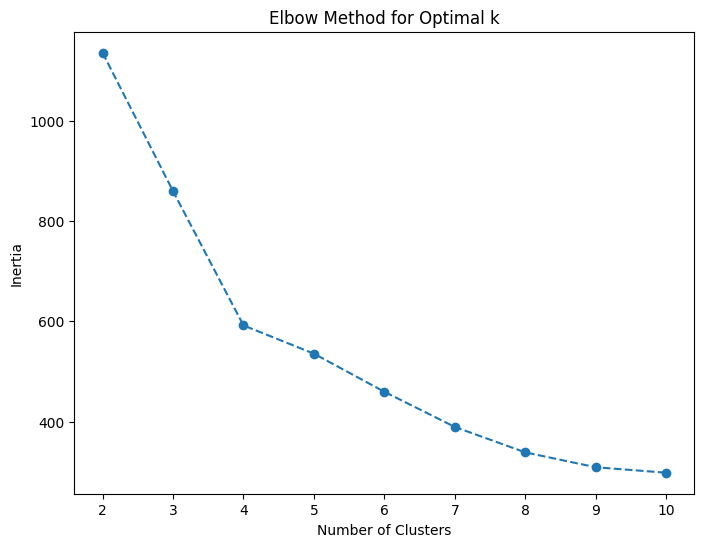

In [4]:
# In this case I was using K-means Clustering Algorithm

# Use the Elbow Method or Silhouette Score to determine the best number of clusters.

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Select the optimal number of clusters (e.g., k=4) and fit the K-means model.

kmeans = KMeans(n_clusters=4, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)


In [5]:
# Evaluate Clustering

# Calculate the Davies-Bouldin Index (lower values indicate better clustering).

from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(scaled_features, customer_features['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")


Davies-Bouldin Index: 0.9435440237978239


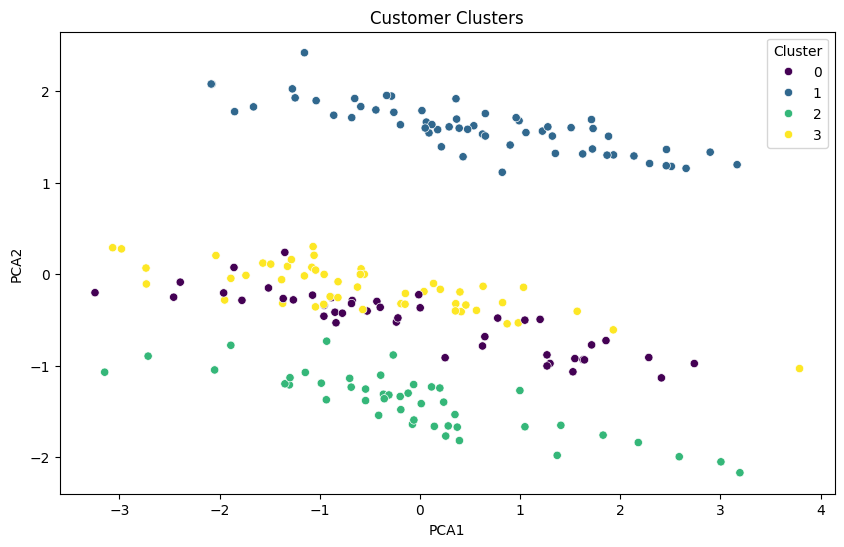

In [6]:
# Visualize clusters using 2D or 3D plots

from sklearn.decomposition import PCA
import seaborn as sns

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Add PCA results to DataFrame
customer_features['PCA1'] = reduced_features[:, 0]
customer_features['PCA2'] = reduced_features[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_features, x='PCA1', y='PCA2', hue='Cluster', palette='viridis')
plt.title('Customer Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()
